# Fruits Classifier
In this project, a simple feed forward fully connected nueral network is implemented to classify 4 classes of fruits from Fruits-360 dataset. In Fruits-360 dataset each class has approximatley 491 images with size of 100x100 pixels. In order to simplify the problem a feature extraction technique had been used, as a result 360 features extracted for each class. After that, a size reduction technique was used and decreased the input size to 102.  
  
The goal of this project is to implement a fully connected nueral network using the following architecture:
![network-architecture](assets/network.JPG)  
For training the network **Stochastic Gradient Descent** was used, implemented in tow forms of iterative backpropagation and vectorized backpropagation.  
  
This network was implemented in 5 steps:  
1. Loading dataset
2. Feedforward implementation
3. Backpropagation using for loops
4. Backpropagation using vectorization
5. Test final model
  
At the end, 4 additional steps was implemented:  
1. Hyperparameter tuning   
2. Improving stochastic gradient descent algorithm  
3. Adding new fruits to current dataset and huperparameter tuning for the new dataset  
4. Using softmax activation function for output layer

# Step 1: Loading dataset
Loading dataset after feature extraction and size reduction.

In [4]:
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

# loading training set features
f = open("Datasets/train_set_features.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("Datasets/train_set_labels.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("Datasets/test_set_features.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("Datasets/test_set_labels.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and lables
train_set = []
test_set = []

for i in range(len(train_set_features)):
    label = np.array([0,0,0,0])
    label[int(train_set_labels[i])] = 1
    label = label.reshape(4,1)
    train_set.append((train_set_features[i].reshape(102,1), label))
    

for i in range(len(test_set_features)):
    label = np.array([0,0,0,0])
    label[int(test_set_labels[i])] = 1
    label = label.reshape(4,1)
    test_set.append((test_set_features[i].reshape(102,1), label))

# shuffle
random.shuffle(train_set)
random.shuffle(test_set)

# print size
print(len(train_set)) #1962
print(len(test_set)) #662

1962
662


# Step 2: Feedforward  
Implementing the following formula on each layer:
$$ a^{(L+1)} = \sigma{(W^{(L+1)}\times{a^{L}} + b^{L+1}) }$$


In [5]:
# Allocate W matrix and vector b for each layer.
def initialize_parameters(layer_dims):

    parameters = {}
    L = len(layer_dims)
    
    center = 0
    margin = 1
    
    for i in range(1, L):
        parameters['W'+str(i)] = np.random.normal(center, margin, size = (layer_dims[i], layer_dims[i-1]))
        parameters['b' + str(i)] = np.zeros((layer_dims[i],1))
        
    return parameters    

In [6]:
layer_dims = [102, 150, 60, 4]
parameters = initialize_parameters(layer_dims)

In [7]:
# check shape of matrices
print(parameters['W1'].shape)
print(parameters['b1'].shape)
print(parameters['W2'].shape)
print(parameters['b2'].shape)
print(parameters['W3'].shape)
print(parameters['b3'].shape)

(150, 102)
(150, 1)
(60, 150)
(60, 1)
(4, 60)
(4, 1)


In [8]:
# Claculate sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [9]:
# Claculate forward process for one layer
def forward_calc(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z = np.dot(W,A_prev) + b
        linear_cache = (A_prev, W, b)
        A = sigmoid(Z)
        cache = (linear_cache, Z)
    return A, cache

In [10]:
# Return output of the network from forward calculations
def model_forward(X, parameters, L):
    caches = []
    A = X
    
    for l in range(1, L):
        A_prev = A 
        A, cache = forward_calc(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "sigmoid")
        caches.append(cache)
            
    return A, caches

In [11]:
# Return accuracy of network's output
def calc_accuracy(data, parameters):
    true = 0
    for i in range(len(data)):
        X = data[i][0]
        Y = np.argmax(data[i][1])
        output, caches = model_forward(X, parameters, 4)
        Y_pred = np.argmax(output)

        if Y == Y_pred:
            true += 1

    acc = true /len(data) 
    return(acc)

Now we want to test our forward process on only 200 of train data.
We expect the average accuracy to be around 25% since weights are random and network is not trained yet.

In [9]:
train_200 = train_set[:200]
test_200 = test_set[:200]

print("accuracy before training: " + str(calc_accuracy(train_200, parameters)*100) + " %")

accuracy before training: 20.5 %


# Step 3: Backpropagation with for loops  
**sum of squared errors (SSE)** was used as a cost function:

$$ Cost = \sum_{j = 0}^{n_L -1 }{{(a_j^{(L)} - y_j)}^2 }$$  


In [12]:
# Compute SSE cost 
def compute_cost(output, Y):
    cost = ((output - Y)**2).sum()
    return cost

In [13]:
# Compute drivation of sigmoid
def sigmoid_deriv(z):
    a = sigmoid(z)
    return a * (1 - a)

## Backpropagation without vectorization:

**Last layer derivatives:**  

#### Weight:
By applying the chain rule, the following formulas wil be obtained:  
$$\displaystyle \frac{\partial Cost}{\partial w_{jk}^{(L)}} = \displaystyle \frac{\partial Cost}{\partial a_{j}^{(L)}} \times \displaystyle \frac{\partial a_{j}^{(L)}}{\partial z_{j}^{(L)}} \times \displaystyle \frac{\partial z_{j}^{(L)}}{\partial w_{jk}^{(L)}} $$

$$\displaystyle \frac{\partial Cost}{\partial w_{jk}^{(L)}} = 2(a_{j}^{(L)} - y_{j}) \times \sigma^{'}(z_{j}^{(L)})\times a_{k}^{(L-1)}$$

#### Bias:
$$\displaystyle \frac{\partial Cost}{\partial b_{j}^{(L)}} = \displaystyle \frac{\partial Cost}{\partial a_{j}^{(L)}} \times \displaystyle \frac{\partial a_{j}^{(L)}}{\partial z_{j}^{(L)}} \times \displaystyle \frac{\partial z_{j}^{(L)}}{\partial b_{j}^{(L)}} $$

$$\displaystyle \frac{\partial Cost}{\partial b_{j}^{(L)}} = 2(a_{j}^{(L)} - y_{j}) \times \sigma^{'}(z_{j}^{(L)})\times 1$$

#### Activation:
 
$$\displaystyle \frac{\partial Cost}{\partial a_{k}^{(L-1)}} = \sum_{j=0}^{n_{(L-1)}} \displaystyle \frac{\partial Cost}{\partial a_{j}^{(L)}} \times \displaystyle \frac{\partial a_{j}^{(L)}}{\partial z_{j}^{(L)}} \times \displaystyle \frac{\partial z_{j}^{(L)}}{\partial a_{k}^{(L-1)}} $$  


**Other layers derivatives:**

#### Weight:

$$\displaystyle \frac{\partial Cost}{\partial w_{km}^{(L-1)}} =  \displaystyle \frac{\partial Cost}{\partial a_{k}^{(L-1)}} \times \sigma^{'}(z_{k}^{(L-1)})\times a_{m}^{(L-2)}$$

#### Bias:

$$\displaystyle \frac{\partial Cost}{\partial b_{k}^{(L-1)}} = \displaystyle \frac{\partial Cost}{\partial a_{k}^{(L-1)}} \times \sigma^{'}(z_{k}^{(L-1)})\times 1$$

#### Activation:

$$\displaystyle \frac{\partial Cost}{\partial a_{m}^{(L-2)}} = \sum_{k=0}^{n_{(L-2)}} (\displaystyle \frac{\partial Cost}{\partial a_{k}^{(L-1)}} \times \sigma^{'}(z_{k}^{(L-1)})\times w_{km}^{(L-1)}) $$


In [12]:
# Compute gradients of wights and biases
def backpropagation(caches, output, y):
    
    a3 = output
    a2 = caches[2][0][0]
    a1 = caches[1][0][0]
    a0 = caches[0][0][0]
    
    z3 = caches[2][1]
    z2 = caches[1][1]
    z1 = caches[0][1]
    
    W3 = caches[2][0][1]
    W2 = caches[1][0][1]
    W1 = caches[0][0][1]
    
    grad_W3 = np.zeros((4, 60))
    for j in range(4):
        for k in range(60):
            grad_W3[j, k] += a2[k, 0] * sigmoid_deriv(z3[j, 0]) * (2 * a3[j,0]- 2 * y[j,0]) 
    
    grad_b2 = np.zeros((4, 1))
    for j in range(4):
        grad_b2[j ,0] += 1 * sigmoid_deriv(z3[j, 0]) * (2 * a3[j,0]- 2 * y[j,0]) 
    
    grad_a2 = np.zeros((60, 1))
    for k in range(60):
        for j in range(4):
            grad_a2[k, 0] += W3[j, k] * sigmoid_deriv(z3[j, 0]) * (2 * a3[j,0]- 2 * y[j,0])
            
    grad_W2 = np.zeros((60, 150))
    for k in range(60):
        for m in range(150):
            grad_W2[k, m] += a1[m, 0] * sigmoid_deriv(z2[k, 0]) * grad_a2[k, 0]
            
    grad_b1 = np.zeros((60, 1))
    for k in range(60):
        grad_b1[k ,0] += 1 * sigmoid_deriv(z2[k, 0]) * grad_a2[k, 0]
        
    grad_a1 = np.zeros((150, 1))
    for m in range(150):
        for k in range(60):
            grad_a1[m, 0] += W2[k, m] * sigmoid_deriv(z2[k, 0]) * grad_a2[k, 0]
            
    grad_W1 = np.zeros((150, 102))
    for m in range(150):
        for v in range(102):
            grad_W1[m, v] += a0[v, 0] * sigmoid_deriv(z1[m, 0]) * grad_a1[m, 0]
            
    grad_b0 = np.zeros((150, 1))
    for m in range(150):
        grad_b0[m ,0] += 1 * sigmoid_deriv(z1[m, 0]) * grad_a1[m, 0]
        
    grads = {}
    grads["db1"] = grad_b0
    grads["db2"] = grad_b1
    grads["db3"] = grad_b2
    grads["dW1"] = grad_W1
    grads["dW2"] = grad_W2
    grads["dW3"] = grad_W3
    
    return grads

## Train process using **Batch Gradient Descent** :

In [62]:
# Apply stochastic gradient descent on input train_set and update weights
def train(train_set, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized):
    
    #Initialize W and b
    parameters = initialize_parameters(layer_dims)
    
    costs = []
    for i in range(number_of_epochs):
        random.shuffle(train_set)
        cost = 0
        for n in range(len(train_set)//batch_size):
            batch = train_set[n * batch_size: (n+1) * batch_size]
            
            grad_W3 = np.zeros((layer_dims[3], layer_dims[2]))
            grad_b3 = np.zeros((layer_dims[3], 1))
            grad_W2 = np.zeros((layer_dims[2], layer_dims[1]))
            grad_b2 = np.zeros((layer_dims[2], 1))
            grad_W1 = np.zeros((layer_dims[1], layer_dims[0]))
            grad_b1 = np.zeros((layer_dims[1], 1))
            
            
            for item in batch:
                X = item[0]
                Y = item[1]
                output, caches = model_forward(X, parameters, len(layer_dims))
                if vectorized:
                    grads = backpropagation_vectorized(caches, output, Y, layer_dims)
                else:
                    grads = backpropagation(caches, output, Y, layer_dims)
                cost += compute_cost(output, Y)
                grad_W3 += grads["dW3"]
                grad_W2 += grads["dW2"]
                grad_W1 += grads["dW1"]
                grad_b3 += grads["db3"]
                grad_b2 += grads["db2"]
                grad_b1 += grads["db1"]
            
            for l in range(len(layer_dims)-1):
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * (grads["dW" + str(l+1)]/ batch_size)
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * (grads["db" + str(l+1)]/ batch_size)
        
        costs.append(cost/len(train_set))
                
    return parameters, costs         

## Train network on 200 train data:

In [14]:
# Set hyperparameters
layer_dims = [102, 150, 60, 4]
learning_rate = 1
number_of_epochs = 5
batch_size = 10 

# Train network
start = time.time()
trained_params, epochs_costs = train(train_200, learning_rate, number_of_epochs, batch_size, layer_dims, False)
end = time.time()

print(f"Runtime of the program is {end - start} seconds")

Runtime of the program is 158.89428067207336 seconds


### Plot cost per epoch:

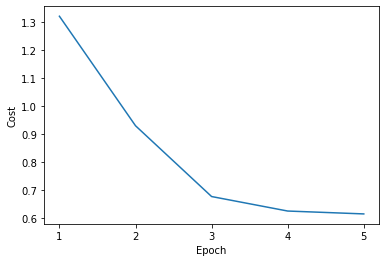

In [15]:
plt.plot(epochs_costs)
plt.xticks(np.arange(len(epochs_costs)), np.arange(1, len(epochs_costs)+1))
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

Calculating final accuracy on 200 train data: 

In [16]:
print("accuracy after training, on train data: " + str(calc_accuracy(train_200, trained_params)*100) + " %")
print("accuracy after training, on test data: " + str(calc_accuracy(test_200, trained_params)*100) + " %")

accuracy after training, on train data: 70.5 %
accuracy after training, on test data: 55.50000000000001 %


# Step 4: Vectorization  

## Backpropagation with vectorization :

In [14]:
def backpropagation_vectorized(caches, output, y, layer_dims):
    
    a3 = output
    a2 = caches[2][0][0]
    a1 = caches[1][0][0]
    a0 = caches[0][0][0]
    
    z3 = caches[2][1]
    z2 = caches[1][1]
    z1 = caches[0][1]
    
    W3 = caches[2][0][1]
    W2 = caches[1][0][1]
    W1 = caches[0][0][1]
        
    grad_W3 = np.zeros((layer_dims[3], layer_dims[2]))
    grad_W3 += (2 * sigmoid_deriv(z3) * (a3 - y)) @ (np.transpose(a2))
    
    grad_b2 = np.zeros((layer_dims[3], 1))
    grad_b2 += (2 * sigmoid_deriv(z3) * (a3 - y))
    
    grad_a2 = np.zeros((layer_dims[2], 1))
    grad_a2 += np.transpose(W3) @ (2 * sigmoid_deriv(z3) * (a3 - y))
    
    grad_W2 = np.zeros((layer_dims[2], layer_dims[1]))
    grad_W2 += (sigmoid_deriv(z2) * grad_a2) @ (np.transpose(a1))
            
    grad_b1 = np.zeros((layer_dims[2], 1))
    grad_b1 += (sigmoid_deriv(z2) * grad_a2)
        
    grad_a1 = np.zeros((layer_dims[1], 1))
    grad_a1 += np.transpose(W2) @ (sigmoid_deriv(z2) * grad_a2)
            
    grad_W1 = np.zeros((layer_dims[1], layer_dims[0]))
    grad_W1 += (sigmoid_deriv(z1) * grad_a1) @ (np.transpose(a0))
            
    grad_b0 = np.zeros((layer_dims[1], 1))
    grad_b0 += (sigmoid_deriv(z1) * grad_a1)
        
    grads = {}
    grads["db1"] = grad_b0
    grads["db2"] = grad_b1
    grads["db3"] = grad_b2
    grads["dW1"] = grad_W1
    grads["dW2"] = grad_W2
    grads["dW3"] = grad_W3
    
    return grads

## Train network on 200 train data: 


In [18]:
# Set hyperparameters
layer_dims = [102, 150, 60, 4]
learning_rate = 1
number_of_epochs = 20
batch_size = 10 

# Train network
start = time.time()
trained_params, epochs_costs = train(train_200, learning_rate, number_of_epochs, batch_size, layer_dims, True)
end = time.time()

print(f"Runtime of the program is {end - start} seconds")

Runtime of the program is 1.3238756656646729 seconds


According to the result there is a big runtime difference compared to training without vectorized back propagation that was in previous part.  

### Plot cost per epoch:

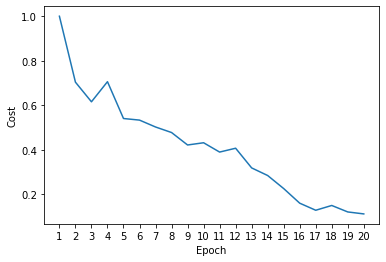

In [19]:
plt.plot(epochs_costs)
plt.xticks(np.arange(len(epochs_costs)), np.arange(1, len(epochs_costs)+1))
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

Calculating final accuracy on 200 train data: 

In [20]:
print("accuracy after training on train data: " + str(calc_accuracy(train_200, trained_params)*100) + " %")
print("accuracy after training on test data: " + str(calc_accuracy(test_200, trained_params)*100) + " %")

accuracy after training on train data: 97.0 %
accuracy after training on test data: 85.0 %


## Check results of the network, trained 10 different times:

In [15]:
# Train network 10 times and return train, test accuracy and costs
def train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized):
    train_accs = []
    test_accs = []
    costs = []
    for i in range(10):
        trained_params, epochs_costs = train(train_set, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized)
        costs.append(epochs_costs)
        train_acc = calc_accuracy(train_set, trained_params)*100
        test_acc = calc_accuracy(test_set, trained_params)*100
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    return train_accs, test_accs, costs

In [16]:
# Plot accuracy in 10 runs
def plot_10_results(train_accs, test_accs):
    plt.title("Train and test accuracy per trial")
    plt.plot(train_accs, label='train accuracy')
    plt.plot(test_accs, label='test accuracy')
    plt.xticks(np.arange(len(test_accs)), np.arange(1, len(test_accs)+1))
    plt.legend()
    plt.xlabel("Trial number")
    plt.ylabel("Accuracy")
    
    mean_test_acc = sum(test_accs)/len(test_accs)
    txt = f"Mean test accuracy for 10 trial is {mean_test_acc}"
    plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show

In [17]:
# Plot costs in 10 runs
def plot_10_costs(costs):
    rows = len(costs)//5
    fig, axs = plt.subplots(rows, 5, sharex=True, sharey=True, figsize=(15,5))
    
    fig.suptitle('Costs per epoch for each trial')
    for i in range(rows):
        for j in range(5):
            axs[i, j].plot(costs[i*5+j])
            axs[i, j].set_title(f'Trial #{i*5+j+1}')
            axs[i, j].set(xlabel='Epoch', ylabel='Cost')
            axs[i, j].label_outer()
            axs[i, j].set_xticks(np.arange(0, len(costs[i*5+j]), 4))
            axs[i, j].set_xticklabels(np.arange(1, len(costs[i*5+j])+1, 4))
    fig.tight_layout()

### Checking average accuracy in 10 runs with learning rate = 1,  epochs = 20 and batch size = 10  
 * Accuracy per trial is plotted  
 * Cost per epoch for each trial is plotted

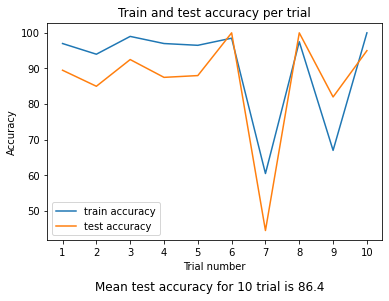

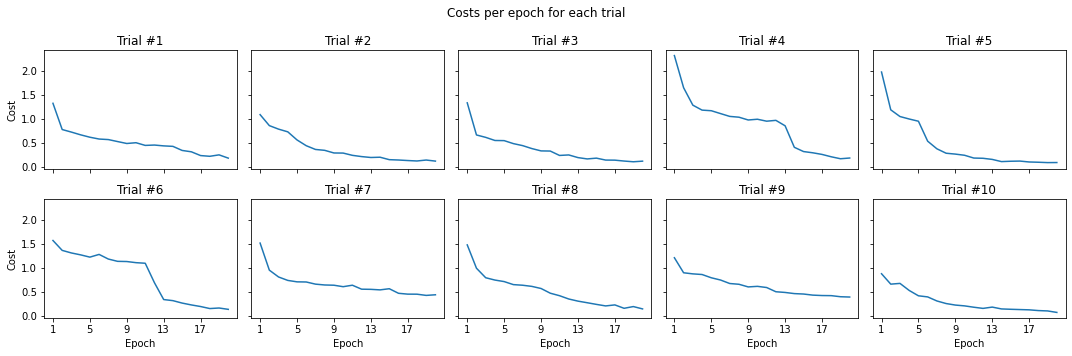

In [25]:
# Set hyperparameters
layer_dims = [102, 150, 60, 4]
learning_rate = 1
number_of_epochs = 20
batch_size = 10 
vectorized = True

train_accs, test_accs, costs = train_10_times(train_200, test_200, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized)
plot_10_results(train_accs, test_accs)
plot_10_costs(costs)

# Step 5: Testing the model

Run algorithm with vectorized back propagation on whole dataset 

In [26]:
layer_dims = [102, 150, 60, 4]
learning_rate = 1
number_of_epochs = 10
batch_size = 10 
vectorized = True

trained_params, epochs_costs = train(train_set, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized)

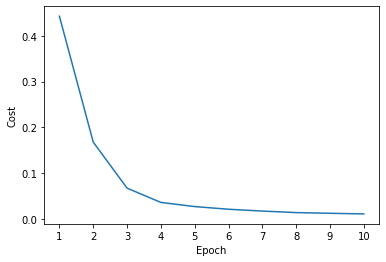

In [27]:
plt.plot(epochs_costs)
plt.xticks(np.arange(len(epochs_costs)), np.arange(1, len(epochs_costs)+1))
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

In [28]:
print("accuracy for train data after training: " + str(calc_accuracy(train_set, trained_params)*100) + " %")
print("accuracy for test data after training: " + str(calc_accuracy(test_set, trained_params)*100) + " %")

accuracy for train data after training: 100.0 %
accuracy for test data after training: 99.8489425981873 %


**Checking average accuracy in 10 trial with learning rate = 1,  epochs = 10 and batch size = 10**

Mean test accuracy for 10 trial is 91.94864048338368


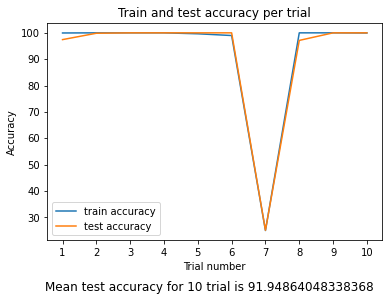

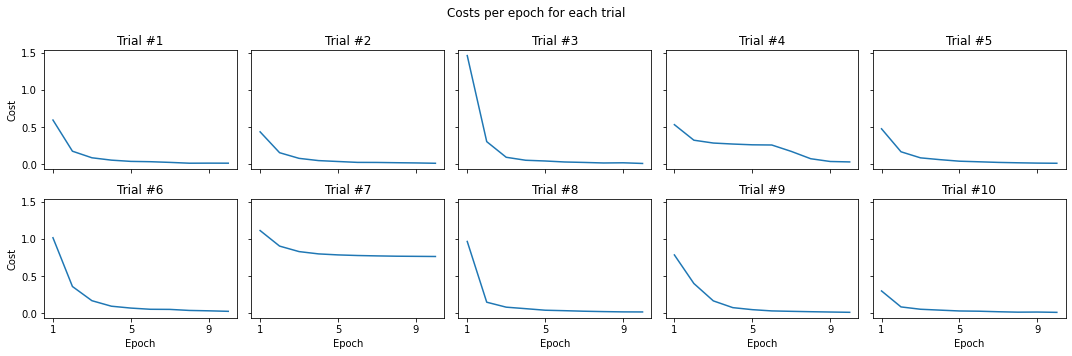

In [29]:
#Average accuracy for 10 runs:
train_accs, test_accs, costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized)
mean_test_acc = sum(test_accs)/len(test_accs)
print(f"Mean test accuracy for 10 trial is {mean_test_acc}")
plot_10_results(train_accs, test_accs)
plot_10_costs(costs)

# Additional part 1: Hyperparameter tuning
As we know Stochastic Gradient Descent may got stuck in local minimums. In order to reduce this problem we need to choose an appropriate learning rate. Here we will run our learning algorithem with different learning rate, epoch and batch size. Then by compairing results a good hyperparameter setup will be found. 

## First experiment:  
* learning_rate = 1
* number_of_epochs = 10
* batch_size = 10 

First experiment: learning rate = 1, epochs = 10, batch size = 10


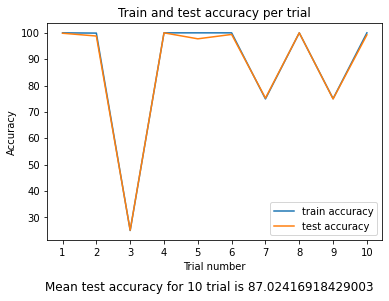

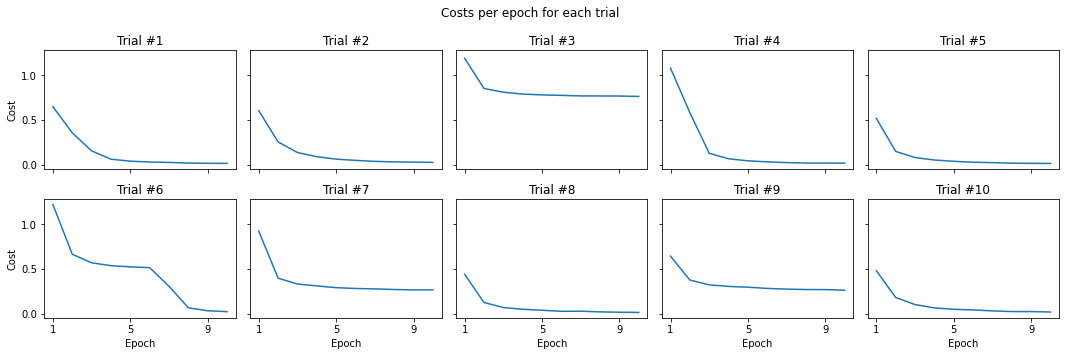

In [98]:
layer_dims = [102, 150, 60, 4]

# First experiment
learning_rate = 1
number_of_epochs = 10
batch_size = 10 

print(f"First experiment: learning rate = {learning_rate}, epochs = {number_of_epochs}, batch size = {batch_size}")
exp1_train_accs, exp1_test_accs, exp1_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, True)
plot_10_results(exp1_train_accs, exp1_test_accs)
plot_10_costs(exp1_costs)

## Second experiment:  
* learning_rate = 2
* number_of_epochs = 10
* batch_size = 10 

Second experiment: learning rate = 2, epochs = 10, batch size = 10


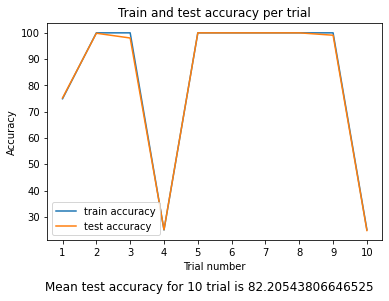

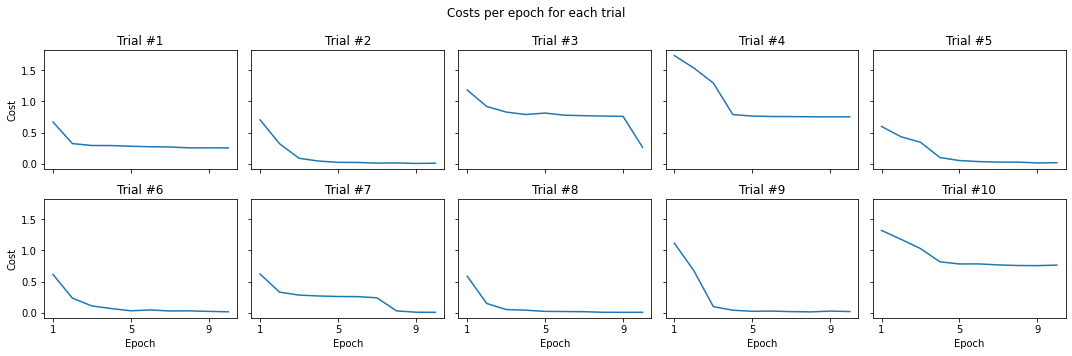

In [99]:
# Second experiment
learning_rate = 2
number_of_epochs = 10
batch_size = 10 

print(f"Second experiment: learning rate = {learning_rate}, epochs = {number_of_epochs}, batch size = {batch_size}")
exp2_train_accs, exp2_test_accs, exp2_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, True)
plot_10_results(exp2_train_accs, exp2_test_accs)
plot_10_costs(exp2_costs)

## Third experiment:  
* learning_rate = 0.5
* number_of_epochs = 10
* batch_size = 10 

Third experiment: learning rate = 0.5, epochs = 10, batch size = 10


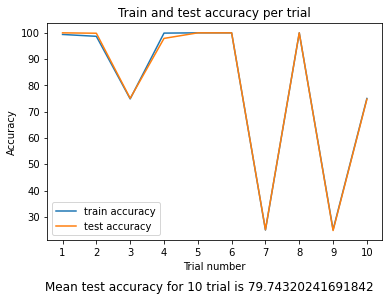

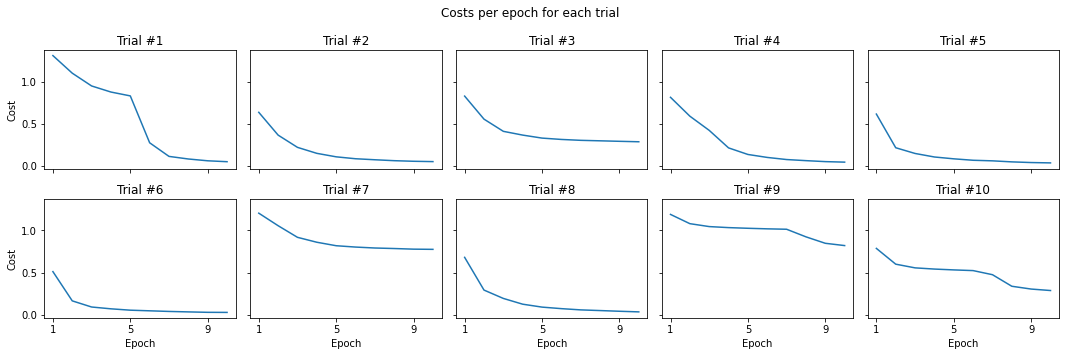

In [100]:
# Third experiment
learning_rate = 0.5
number_of_epochs = 10
batch_size = 10 

print(f"Third experiment: learning rate = {learning_rate}, epochs = {number_of_epochs}, batch size = {batch_size}")
exp3_train_accs, exp3_test_accs, exp3_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, True)
plot_10_results(exp3_train_accs, exp3_test_accs)
plot_10_costs(exp3_costs)

## Forth experiment:  
* learning_rate = 0.5
* number_of_epochs = 20
* batch_size = 10 

Forth experiment: learning rate = 0.5, epochs = 20, batch size = 10


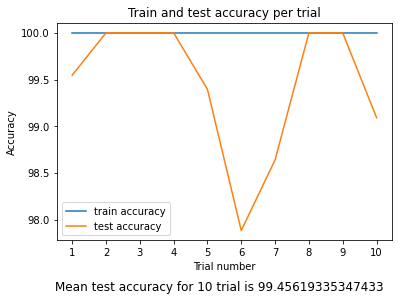

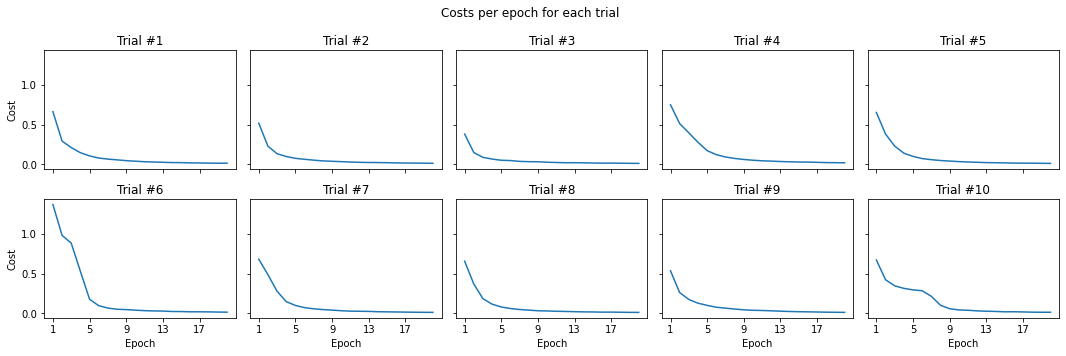

In [103]:
# Forth experiment
learning_rate = 0.5
number_of_epochs = 20
batch_size = 10 

print(f"Forth experiment: learning rate = {learning_rate}, epochs = {number_of_epochs}, batch size = {batch_size}")
exp4_train_accs, exp4_test_accs, exp4_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, True)
plot_10_results(exp4_train_accs, exp4_test_accs)
plot_10_costs(exp4_costs)

## Fifth experiment:  
* learning_rate = 0.2
* number_of_epochs = 25
* batch_size = 10 

Fifth experiment: learning rate = 0.2, epochs = 25, batch size = 10


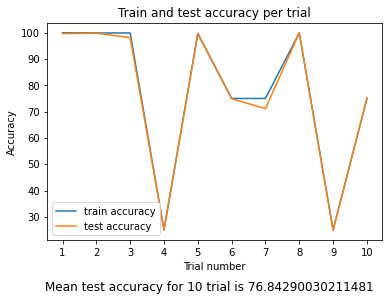

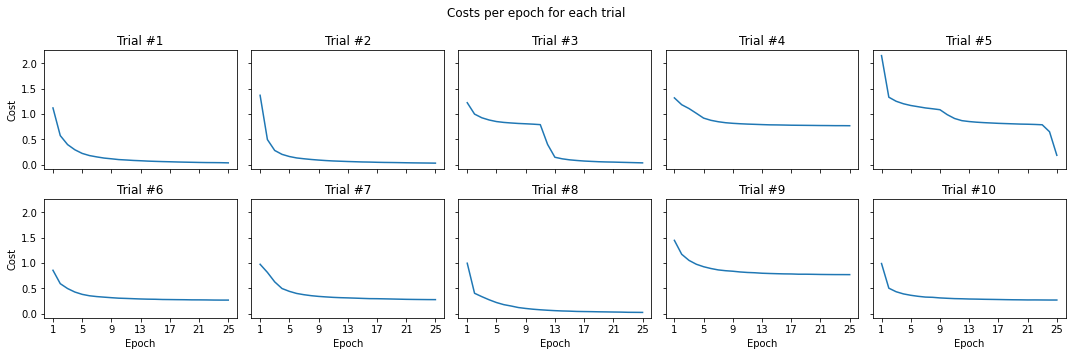

In [105]:
# Fifth experiment
learning_rate = 0.2
number_of_epochs = 25
batch_size = 10 

print(f"Fifth experiment: learning rate = {learning_rate}, epochs = {number_of_epochs}, batch size = {batch_size}")
exp5_train_accs, exp5_test_accs, exp5_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, True)
plot_10_results(exp5_train_accs, exp5_test_accs)
plot_10_costs(exp5_costs)

## Sixth experiment:  
* learning_rate = 0.01
* number_of_epochs = 25
* batch_size = 10 

sixth experiment: learning rate = 0.01, epochs = 25, batch size = 10


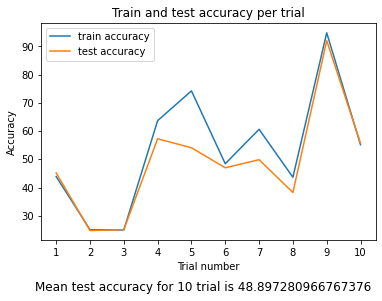

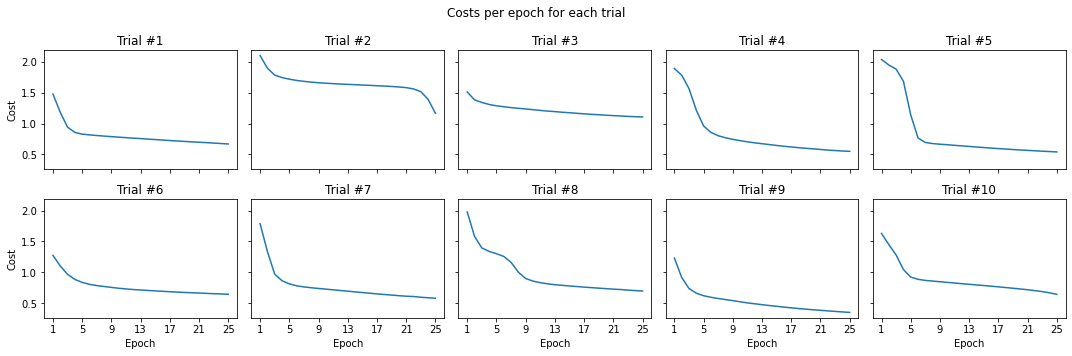

In [106]:
# sixth experiment
learning_rate = 0.01
number_of_epochs = 25
batch_size = 10 

print(f"sixth experiment: learning rate = {learning_rate}, epochs = {number_of_epochs}, batch size = {batch_size}")
exp6_train_accs, exp6_test_accs, exp6_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, True)
plot_10_results(exp6_train_accs, exp6_test_accs)
plot_10_costs(exp6_costs)

## Seventh experiment:  
* learning_rate = 0.5
* number_of_epochs = 20
* batch_size = 20 

seventh experiment: learning rate = 0.5, epochs = 20, batch size = 20


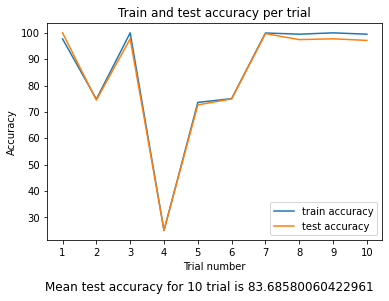

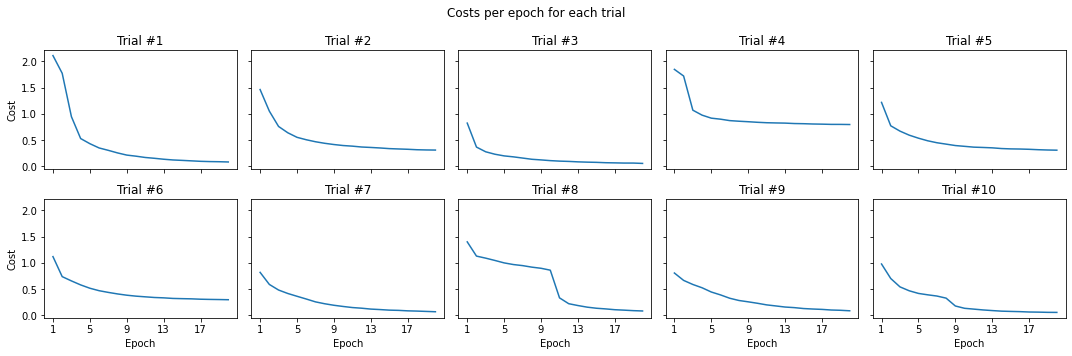

In [107]:
# seventh experiment
learning_rate = 0.5
number_of_epochs = 20
batch_size = 20 

print(f"seventh experiment: learning rate = {learning_rate}, epochs = {number_of_epochs}, batch size = {batch_size}")
exp7_train_accs, exp7_test_accs, exp7_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, True)
plot_10_results(exp7_train_accs, exp7_test_accs)
plot_10_costs(exp7_costs)

## Eighth experiment:  
* learning_rate = 0.5
* number_of_epochs = 20
* batch_size = 50

eighth experiment: learning rate = 0.5, epochs = 20, batch size = 50


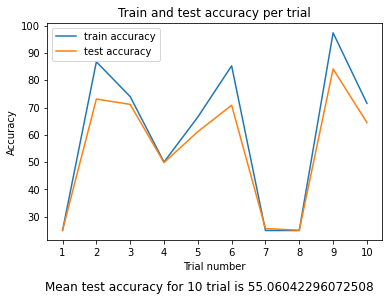

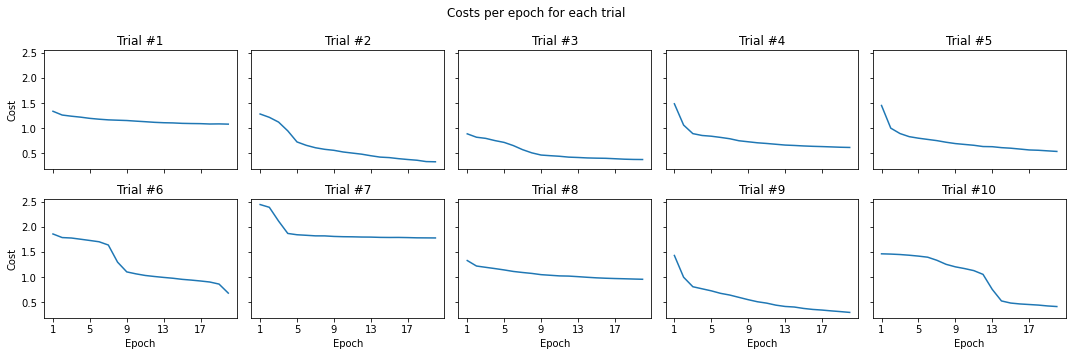

In [108]:
# eighth experiment
learning_rate = 0.5
number_of_epochs = 20
batch_size = 50

print(f"eighth experiment: learning rate = {learning_rate}, epochs = {number_of_epochs}, batch size = {batch_size}")
exp8_train_accs, exp8_test_accs, exp8_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, True)
plot_10_results(exp8_train_accs, exp8_test_accs)
plot_10_costs(exp8_costs)

## Nineth experiment:  
* learning_rate = 0.5
* number_of_epochs = 20
* batch_size = 5

nineth experiment: learning rate = 0.5, epochs = 20, batch size = 5


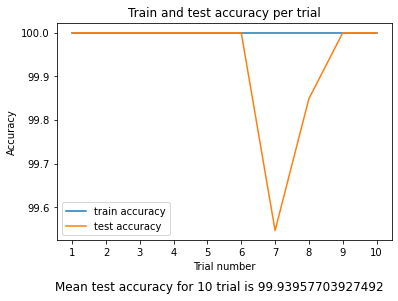

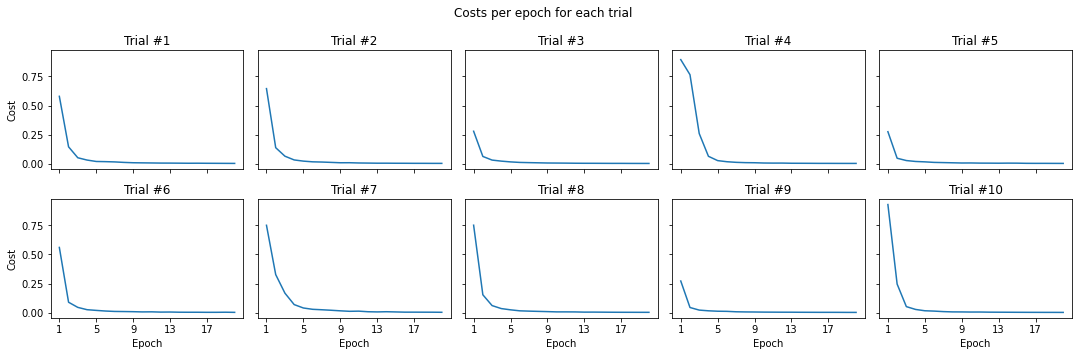

In [109]:
# nineth experiment
learning_rate = 0.5
number_of_epochs = 20
batch_size = 5

print(f"nineth experiment: learning rate = {learning_rate}, epochs = {number_of_epochs}, batch size = {batch_size}")
exp9_train_accs, exp9_test_accs, exp9_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, True)
plot_10_results(exp9_train_accs, exp9_test_accs)
plot_10_costs(exp9_costs)

## Conclusion:  
* **Learning rate and number of epochs**: 
![image.png](assets/download.png)  

The learning rate controls how quickly the model is adaptes to the problem.
A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck and results in underfitting.  
Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.  

Compairing results from first and second experiments, we can conclude that a learning rate = 2 is too high for our problem.  
So in third experiment i decrease learning rate to 0.5. By looking at cost plots in this experiment we can say that the algorithm needs to train longer in order to get a better result.  
So in forth experiment i increased number of epochs to 25 which resulted in a very high accuracy.  
I decided to test even smaller learning rates with higher number of epochs in fifth and sixth experiments but the result was not favorable.  
So i chose learning rate = 0.5 and epoch number = 20 for furthur experiments on batch size.  
* **Batch size**:  

It is well known that too large of a batch size will lead to poor generalization
In 8th and 7th experiments i increased batch size and it didn't have a good outcome
So i tried smaller batch size in ninth experiment and it was the best result among all other experiments.

### **So i found learning rate = 0.5, epoch number = 20 and batch size = 5 as a really good hyperparameter setup for this problem.**

# Additional part 2
Despite choosing a good learning rate, there is still a chance to stuck in local minimums. So we need to use a better version of Stochastic gradient descent or find a way to improve it. 
### Gradient descent with momentum
Instead of depending only on the current gradient to update the weight, gradient descent with momentum (Polyak, 1964) replaces the current gradient with m (“momentum”), which is an aggregate of gradients. This aggregate is the exponential moving average of current and past gradients.

This formula had been used to implement momentum:
$$W_{t+1} = W_{t} - \alpha * M_{t} $$
$$M_{t} = \beta * M_{t-1} + (1 - \beta)* \frac{\partial L}{\partial W} $$  
  
Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable $m$. Formally, this will be the exponentially weighted average of the gradient on previous steps. We can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill.

In [18]:
# Apply stochastic gradient descent with momentum on input train_set and update weights
def train_momentum(train_set, learning_rate, number_of_epochs, batch_size, layer_dims):
    
    #Initialize W and b
    parameters = initialize_parameters(layer_dims)
    #Initialize M to zero
    for i in range(1, len(layer_dims)):
        parameters['M_W'+str(i)] = 0
        parameters['M_b' + str(i)] = 0
    beta = 0.75
    
    costs = []
    for i in range(number_of_epochs):
        random.shuffle(train_set)
        cost = 0
        for n in range(len(train_set)//batch_size):
            batch = train_set[n * batch_size: (n+1) * batch_size]
            
            grad_W3 = np.zeros((4, 60))
            grad_b3 = np.zeros((4, 1))
            grad_W2 = np.zeros((60, 150))
            grad_b2 = np.zeros((60, 1))
            grad_W1 = np.zeros((150, 102))
            grad_b1 = np.zeros((150, 1))
            
            
            for item in batch:
                X = item[0]
                Y = item[1]
                output, caches = model_forward(X, parameters, len(layer_dims))
                grads = backpropagation_vectorized(caches, output, Y, layer_dims)
                cost += compute_cost(output, Y)
                
                
                grad_W3 += grads["dW3"]
                grad_W2 += grads["dW2"]
                grad_W1 += grads["dW1"]
                grad_b3 += grads["db3"]
                grad_b2 += grads["db2"]
                grad_b1 += grads["db1"]
            
            for l in range(len(layer_dims)-1):
#                 Momentum added
                parameters["M_W"+ str(l+1)] = beta * parameters["M_W"+ str(l+1)] + (1 - beta) * (grads["dW" + str(l+1)]/ batch_size)
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * parameters["M_W"+ str(l+1)]
                
                parameters["M_b"+ str(l+1)] = beta * parameters["M_b"+ str(l+1)] + (1 - beta) * (grads["db" + str(l+1)]/ batch_size)
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * parameters["M_b"+ str(l+1)]
        
        costs.append(cost/len(train_set))
                
    return parameters, costs  

In [19]:
def train_momentum_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims):
    train_accs = []
    test_accs = []
    costs = []
    for i in range(10):
        trained_params, epochs_costs = train_momentum(train_set, learning_rate, number_of_epochs, batch_size, layer_dims)
        costs.append(epochs_costs)
        train_acc = calc_accuracy(train_set, trained_params)*100
        test_acc = calc_accuracy(test_set, trained_params)*100
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    return train_accs, test_accs, costs

Mean test accuracy for 10 trial is 97.46223564954683


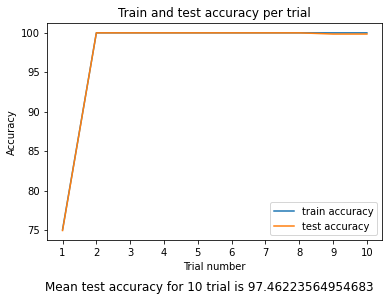

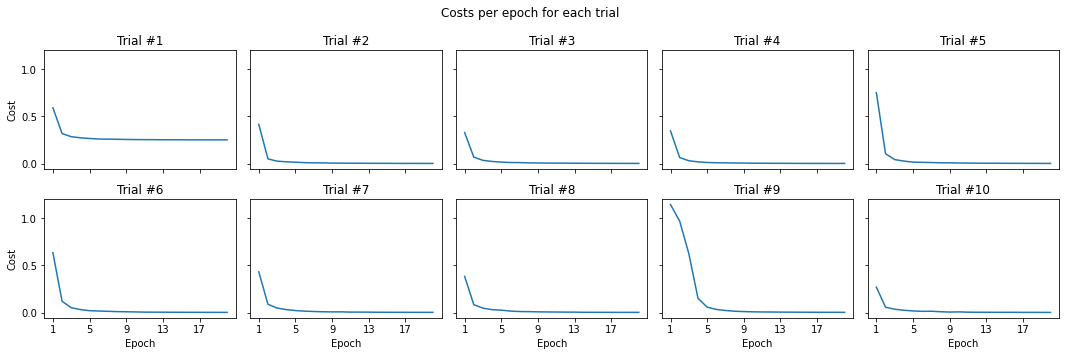

In [21]:
layer_dims = [102, 150, 60, 4]
learning_rate = 0.5
number_of_epochs = 20
batch_size = 5 

m1_train_accs, m1_test_accs, m1_costs = train_momentum_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims)
mean_test_acc = sum(m1_test_accs)/len(m1_test_accs)
print(f"Mean test accuracy for 10 trial is {mean_test_acc}")
plot_10_results(m1_train_accs, m1_test_accs)
plot_10_costs(m1_costs)

### **It can be observed that momentum had improved our training process noticeably.**

# Additional part 3
Add more fruits from Fruit-360 to train and test dataset and try tunning parameters.  
I added Banana to current dataset.

## Creating and loading new dataset

In [76]:
import skimage.io, skimage.color, skimage.feature
import os
import pickle

fruits = ["apple", "lemon", "mango", "raspberry", "Banana"]
#492+490+490+490+490=2452
dataset_features = numpy.zeros(shape=(2452, 360))
outputs = numpy.zeros(shape=(2452))

idx = 0
class_label = 0
for fruit_dir in fruits:
    curr_dir = os.path.join(os.path.sep + "Datasets/Fruits-360/Train", fruit_dir)
    all_imgs = os.listdir(os.getcwd()+curr_dir)
    for img_file in all_imgs:
        if img_file.endswith(".jpg"): # Ensures reading only JPG files.
            fruit_data = skimage.io.imread(fname=os.path.sep.join([os.getcwd(), curr_dir, img_file]), as_gray=False)
            fruit_data_hsv = skimage.color.rgb2hsv(rgb=fruit_data)
            hist = numpy.histogram(a=fruit_data_hsv[:, :, 0], bins=360)
            dataset_features[idx, :] = hist[0]
            outputs[idx] = class_label
            idx = idx + 1
    class_label = class_label + 1

with open("New_Dataset/train_set_features.pkl", "wb") as f:
    pickle.dump(dataset_features, f)

with open("New_Dataset/train_set_labels.pkl", "wb") as f:
    pickle.dump(outputs, f)

In [77]:
fruits = ["apple", "lemon", "mango", "raspberry", "Banana"]
#164+166+166+166+166=830
dataset_features = numpy.zeros(shape=(830, 360))
outputs = numpy.zeros(shape=(830))

idx = 0
class_label = 0
for fruit_dir in fruits:
    curr_dir = os.path.join(os.path.sep + "Datasets/Fruits-360/Test", fruit_dir)
    all_imgs = os.listdir(os.getcwd()+curr_dir)
    for img_file in all_imgs:
        if img_file.endswith(".jpg"): # Ensures reading only JPG files.
            fruit_data = skimage.io.imread(fname=os.path.sep.join([os.getcwd(), curr_dir , img_file]), as_gray=False)
            fruit_data_hsv = skimage.color.rgb2hsv(rgb=fruit_data)
            hist = numpy.histogram(a=fruit_data_hsv[:, :, 0], bins=360)
            dataset_features[idx, :] = hist[0]
            outputs[idx] = class_label
            idx = idx + 1
    class_label = class_label + 1

with open("New_Dataset/test_set_features.pkl", "wb") as f:
    pickle.dump(dataset_features, f)

with open("New_Dataset/test_set_labels.pkl", "wb") as f:
    pickle.dump(outputs, f)

In [80]:
# loading training set features
f = open("New_Dataset/train_set_features.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("New_Dataset/train_set_labels.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("New_Dataset/test_set_features.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("New_Dataset/test_set_labels.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and lables
new_train_set = []
new_test_set = []

for i in range(len(train_set_features)):
    label = np.array([0,0,0,0,0])
    label[int(train_set_labels[i])] = 1
    label = label.reshape(5,1)
    new_train_set.append((train_set_features[i].reshape(104,1), label))
    

for i in range(len(test_set_features)):
    label = np.array([0,0,0,0,0])
    label[int(test_set_labels[i])] = 1
    label = label.reshape(5,1)
    new_test_set.append((test_set_features[i].reshape(104,1), label))

# shuffle
random.shuffle(new_train_set)
random.shuffle(new_test_set)

# print size
print(len(new_train_set)) #2452
print(len(new_test_set)) #830

2452
830


## Training network on new dataset

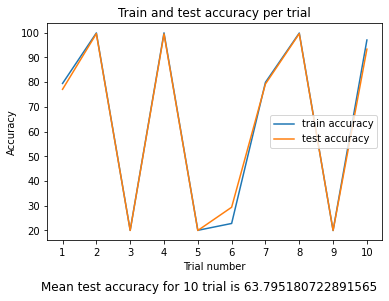

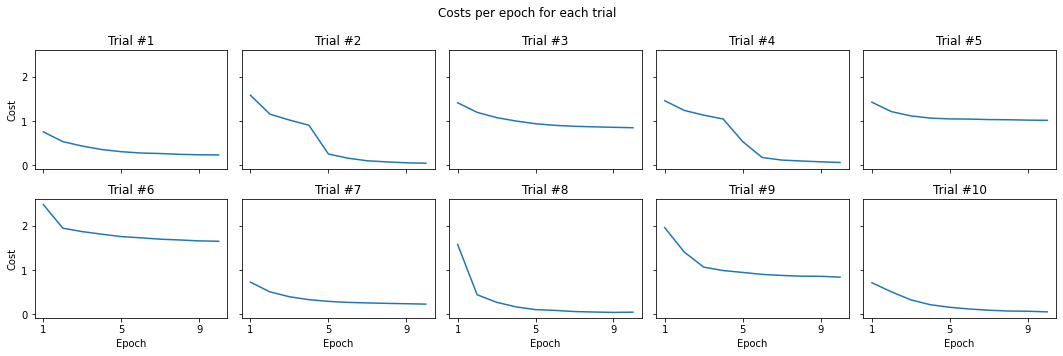

In [87]:
layer_dims = [104, 150, 60, 5]
learning_rate = 1
number_of_epochs = 10
batch_size = 10 
vectorized = True

new_train_accs, new_test_accs, new_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized)
plot_10_results(new_train_accs, new_test_accs)
plot_10_costs(new_costs)

**A meaningfull decrease in mean accuracy is observable so hyperparameters like number of neurons in each layer have to be changed** 

## Hyperparameter tuning network on new dataset

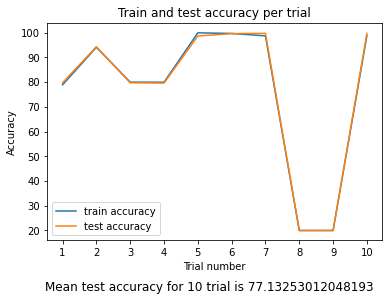

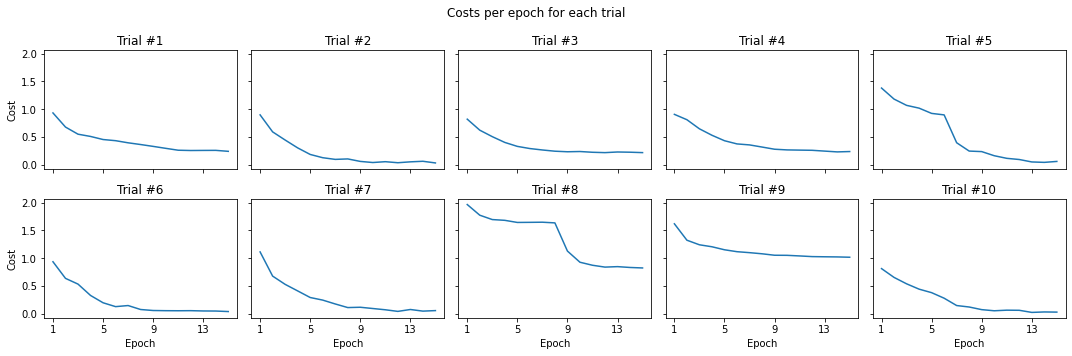

In [90]:
layer_dims = [104, 150, 100, 5]
learning_rate = 2
number_of_epochs = 15
batch_size = 15
vectorized = True

new_train_accs, new_test_accs, new_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized)
plot_10_results(new_train_accs, new_test_accs)
plot_10_costs(new_costs)

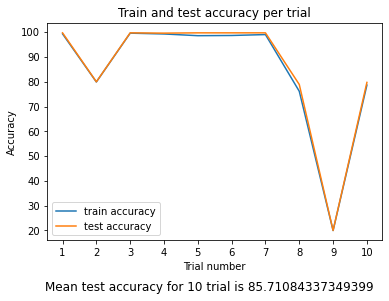

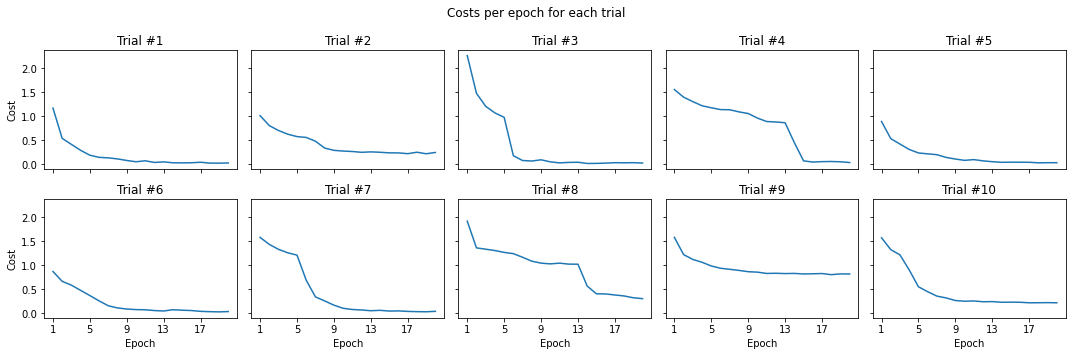

In [91]:
layer_dims = [104, 170, 100, 5]
learning_rate = 2
number_of_epochs = 20
batch_size = 15
vectorized = True

new_train_accs, new_test_accs, new_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized)
plot_10_results(new_train_accs, new_test_accs)
plot_10_costs(new_costs)

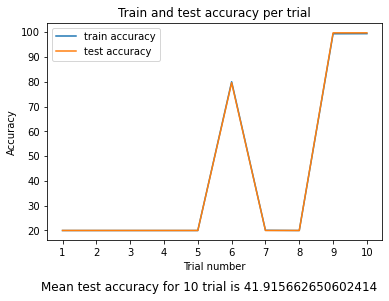

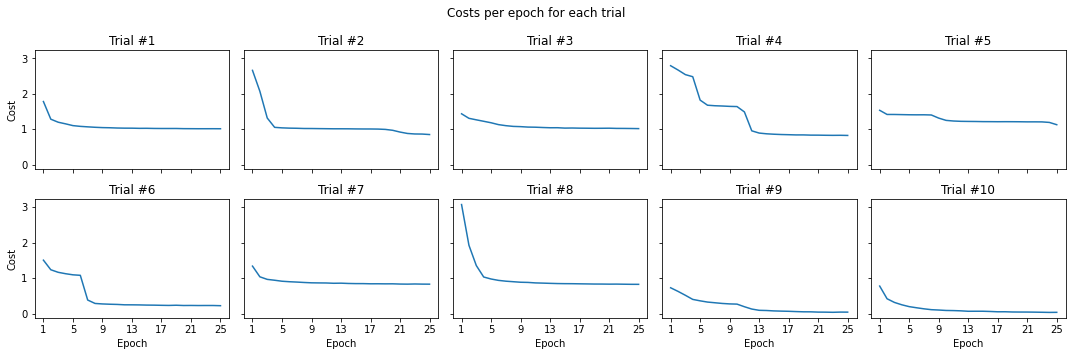

In [94]:
layer_dims = [104, 200, 160, 5]
learning_rate = 0.5
number_of_epochs = 25
batch_size = 15
vectorized = True

new_train_accs, new_test_accs, new_costs = train_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized)
plot_10_results(new_train_accs, new_test_accs)
plot_10_costs(new_costs)

**According to above experiments, a good hyperparameter setup can be:**  
   * layer_dims = [104, 170, 100, 5]
   * learning_rate = 2
   * number_of_epochs = 20
   * batch_size = 15

# Additional part 4
**Use softmax as output layer activation function to normalize outputs**  
Softmax activation function:
$$ \sigma{(z)_i} = \frac{e^{zi}}{\sum_{j = 1}^{K}{e^{z_j}}} $$

Softmax function is prone to two issues: overflow and underflow

* Overflow: It occurs when very large numbers are approximated as infinity
* Underflow: It occurs when very small numbers (near zero in the number line) are approximated (i.e. rounded to) as zero

To combat these issues when doing softmax computation, a common trick is to shift the input vector by subtracting the maximum element in it from all elements.

In [26]:
def stable_softmax(x):
    z = x - max(x)
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    softmax = numerator/denominator

    return softmax

In [34]:
def forward_calc(A_prev, W, b, activation):
    Z = np.dot(W,A_prev) + b
    linear_cache = (A_prev, W, b)
    if activation == "sigmoid":
        A = sigmoid(Z)
        cache = (linear_cache, Z)
    if activation == "softmax":
        A = stable_softmax(Z)
        cache = (linear_cache, Z)
        
    return A, cache

In [28]:
def model_forward(X, parameters, L):
    caches = []
    A = X
    
    for l in range(1, L-1):
        A_prev = A 
        A, cache = forward_calc(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "sigmoid")
        caches.append(cache)
    
    A_prev = A 
    A, cache = forward_calc(A_prev, parameters['W' + str(L-1)], parameters['b' + str(L-1)], "softmax")
    caches.append(cache)
    
    return A, caches

The **categorical cross-entropy loss** is exclusively used in multi-class classification tasks, where each sample belongs exactly to one of the 𝙲 classes.
$$ Loss = - \sum_{i=0}^{c} y_{i}* \log{a_{i}}$$

In [29]:
def compute_CrossEntropy(output, Y):
    
    logprobs = (np.where(Y==1,np.log(output), 0))
    cost = (-1) * np.sum(logprobs)
    
    return cost

**Back propagation:**  
The First step will be to calculate the derivative of the Loss function. I did it as shown in the image below:
![image.png](assets/1.png)  
  
  
Now we will use the previously derived derivative of Cross-Entropy Loss with Softmax to complete the Backpropagation.  
For the final output layer we can define as:  

![image-2.png](assets/2.png)  

For all other layers except the output layer we can define as:  

![image-3.png](assets/3.png)  



In [38]:
def backpropagation_with_softmax(caches, output, y, layer_dims):
    
    a3 = output
    a2 = caches[2][0][0]
    a1 = caches[1][0][0]
    a0 = caches[0][0][0]
    
    z3 = caches[2][1]
    z2 = caches[1][1]
    z1 = caches[0][1]
    
    W3 = caches[2][0][1]
    W2 = caches[1][0][1]
    W1 = caches[0][0][1]
    
    dZ = a3 - y
        
    grad_W3 = np.zeros((layer_dims[3], layer_dims[2]))
    grad_W3 += dZ.dot(a2.T)
    
    grad_b2 = np.zeros((layer_dims[3], 1))
    grad_b2 += np.sum(dZ, axis=1, keepdims=True)
    
    grad_a2 = np.zeros((layer_dims[2], 1))
    grad_a2 += np.transpose(W3).dot(dZ)
    
    grad_W2 = np.zeros((layer_dims[2], layer_dims[1]))
    grad_W2 += (sigmoid_deriv(z2) * grad_a2) @ (np.transpose(a1))
            
    grad_b1 = np.zeros((layer_dims[2], 1))
    grad_b1 += (sigmoid_deriv(z2) * grad_a2)
        
    grad_a1 = np.zeros((layer_dims[1], 1))
    grad_a1 += np.transpose(W2) @ (sigmoid_deriv(z2) * grad_a2)
            
    grad_W1 = np.zeros((layer_dims[1], layer_dims[0]))
    grad_W1 += (sigmoid_deriv(z1) * grad_a1) @ (np.transpose(a0))
            
    grad_b0 = np.zeros((layer_dims[1], 1))
    grad_b0 += (sigmoid_deriv(z1) * grad_a1)
        
    grads = {}
    grads["db1"] = grad_b0
    grads["db2"] = grad_b1
    grads["db3"] = grad_b2
    grads["dW1"] = grad_W1
    grads["dW2"] = grad_W2
    grads["dW3"] = grad_W3
    
    return grads

In [39]:
def train(train_set, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized):
    
    #Initialize W and b
    parameters = initialize_parameters(layer_dims)
    
    costs = []
    for i in range(number_of_epochs):
        random.shuffle(train_set)
        cost = 0
        for n in range(len(train_set)//batch_size):
            batch = train_set[n * batch_size: (n+1) * batch_size]
            
            grad_W3 = np.zeros((layer_dims[3], layer_dims[2]))
            grad_b3 = np.zeros((layer_dims[3], 1))
            grad_W2 = np.zeros((layer_dims[2], layer_dims[1]))
            grad_b2 = np.zeros((layer_dims[2], 1))
            grad_W1 = np.zeros((layer_dims[1], layer_dims[0]))
            grad_b1 = np.zeros((layer_dims[1], 1))
            
            
            for item in batch:
                X = item[0]
                Y = item[1]
                output, caches = model_forward(X, parameters, len(layer_dims))
                grads = backpropagation_with_softmax(caches, output, Y, layer_dims)
                cost += compute_CrossEntropy(output, Y)
                grad_W3 += grads["dW3"]
                grad_W2 += grads["dW2"]
                grad_W1 += grads["dW1"]
                grad_b3 += grads["db3"]
                grad_b2 += grads["db2"]
                grad_b1 += grads["db1"]
            
            for l in range(len(layer_dims)-1):
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * (grads["dW" + str(l+1)]/ batch_size)
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * (grads["db" + str(l+1)]/ batch_size)
        
        costs.append(cost/len(train_set))
                
    return parameters, costs 

In [42]:
layer_dims = [102, 150, 60, 4]
learning_rate = 1
number_of_epochs = 10
batch_size = 10 
vectorized = True

trained_params, epochs_costs = train(train_set, learning_rate, number_of_epochs, batch_size, layer_dims, vectorized)

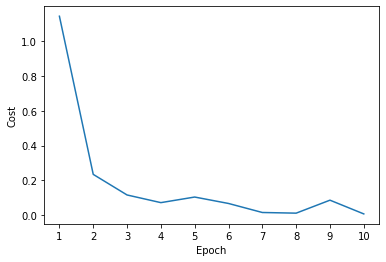

In [43]:
plt.plot(epochs_costs)
plt.xticks(np.arange(len(epochs_costs)), np.arange(1, len(epochs_costs)+1))
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

In [47]:
print("accuracy for train data after training: " + str(calc_accuracy(train_set, trained_params)*100) + " %")
print("accuracy for test data after training: " + str(calc_accuracy(test_set, trained_params)*100) + " %")

accuracy for train data after training: 100.0 %
accuracy for test data after training: 99.8489425981873 %
